In [42]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder

import seaborn as sns
import cv2
import random
from random import randint
import time
from PIL import Image
from scipy import ndimage

from tqdm.notebook import tqdm

from sklearn.metrics import f1_score

In [43]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [44]:
DATA_DIR = "../input/dog-breed-identification/"


TRAIN_DIR = DATA_DIR + "train"                           
TEST_DIR = DATA_DIR + "test"                             

TRAIN_CSV = DATA_DIR + "labels.csv"                     
TEST_CSV =  DATA_DIR + "submission.csv" 

In [45]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, list_IDs, labels,root_dir, transforms= T.ToTensor()):
        self.root_dir= root_dir
        self.labels = labels
        self.list_IDs = list_IDs
        self.transforms=transforms

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.load('kaggle/input/dog-breed-classification' + ID + '.pt')
        y = self.labels[ID]

        return X, y
    
    
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['id'], row['lbl']
        img_fname = self.root_dir + "/" + str(img_id) + ".jpg"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, img_label

In [46]:
data_df = pd.read_csv(TRAIN_CSV)
data_df.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [47]:
labels_names=data_df["breed"].unique()
labels_sorted=labels_names.sort()

labels = dict(zip(range(len(labels_names)),labels_names))
labels 

{0: 'affenpinscher',
 1: 'afghan_hound',
 2: 'african_hunting_dog',
 3: 'airedale',
 4: 'american_staffordshire_terrier',
 5: 'appenzeller',
 6: 'australian_terrier',
 7: 'basenji',
 8: 'basset',
 9: 'beagle',
 10: 'bedlington_terrier',
 11: 'bernese_mountain_dog',
 12: 'black-and-tan_coonhound',
 13: 'blenheim_spaniel',
 14: 'bloodhound',
 15: 'bluetick',
 16: 'border_collie',
 17: 'border_terrier',
 18: 'borzoi',
 19: 'boston_bull',
 20: 'bouvier_des_flandres',
 21: 'boxer',
 22: 'brabancon_griffon',
 23: 'briard',
 24: 'brittany_spaniel',
 25: 'bull_mastiff',
 26: 'cairn',
 27: 'cardigan',
 28: 'chesapeake_bay_retriever',
 29: 'chihuahua',
 30: 'chow',
 31: 'clumber',
 32: 'cocker_spaniel',
 33: 'collie',
 34: 'curly-coated_retriever',
 35: 'dandie_dinmont',
 36: 'dhole',
 37: 'dingo',
 38: 'doberman',
 39: 'english_foxhound',
 40: 'english_setter',
 41: 'english_springer',
 42: 'entlebucher',
 43: 'eskimo_dog',
 44: 'flat-coated_retriever',
 45: 'french_bulldog',
 46: 'german_sheph

In [48]:
lbl=[]
path_img=[]

for i in range(len(data_df["breed"])):
    temp1=list(labels.values()).index(data_df.breed[i])
    lbl.append(temp1)
    temp2=TRAIN_DIR + "/" + str(data_df.id[i]) + ".jpg"
    path_img.append(temp2)

data_df['path_img'] =path_img  
data_df['lbl'] = lbl

data_df.head()

,id,breed,path_img,lbl
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,../input/dog-breed-identification/train/000bec...,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,../input/dog-breed-identification/train/001513...,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,../input/dog-breed-identification/train/001cdf...,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,../input/dog-breed-identification/train/00214f...,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,../input/dog-breed-identification/train/0021f9...,49


In [49]:
num_images = len(data_df["id"])
print('Number of images in Training file:', num_images)
no_labels=len(labels_names)
print('Number of dog breeds in Training file:', no_labels)

Number of images in Training file: 10222
Number of dog breeds in Training file: 120


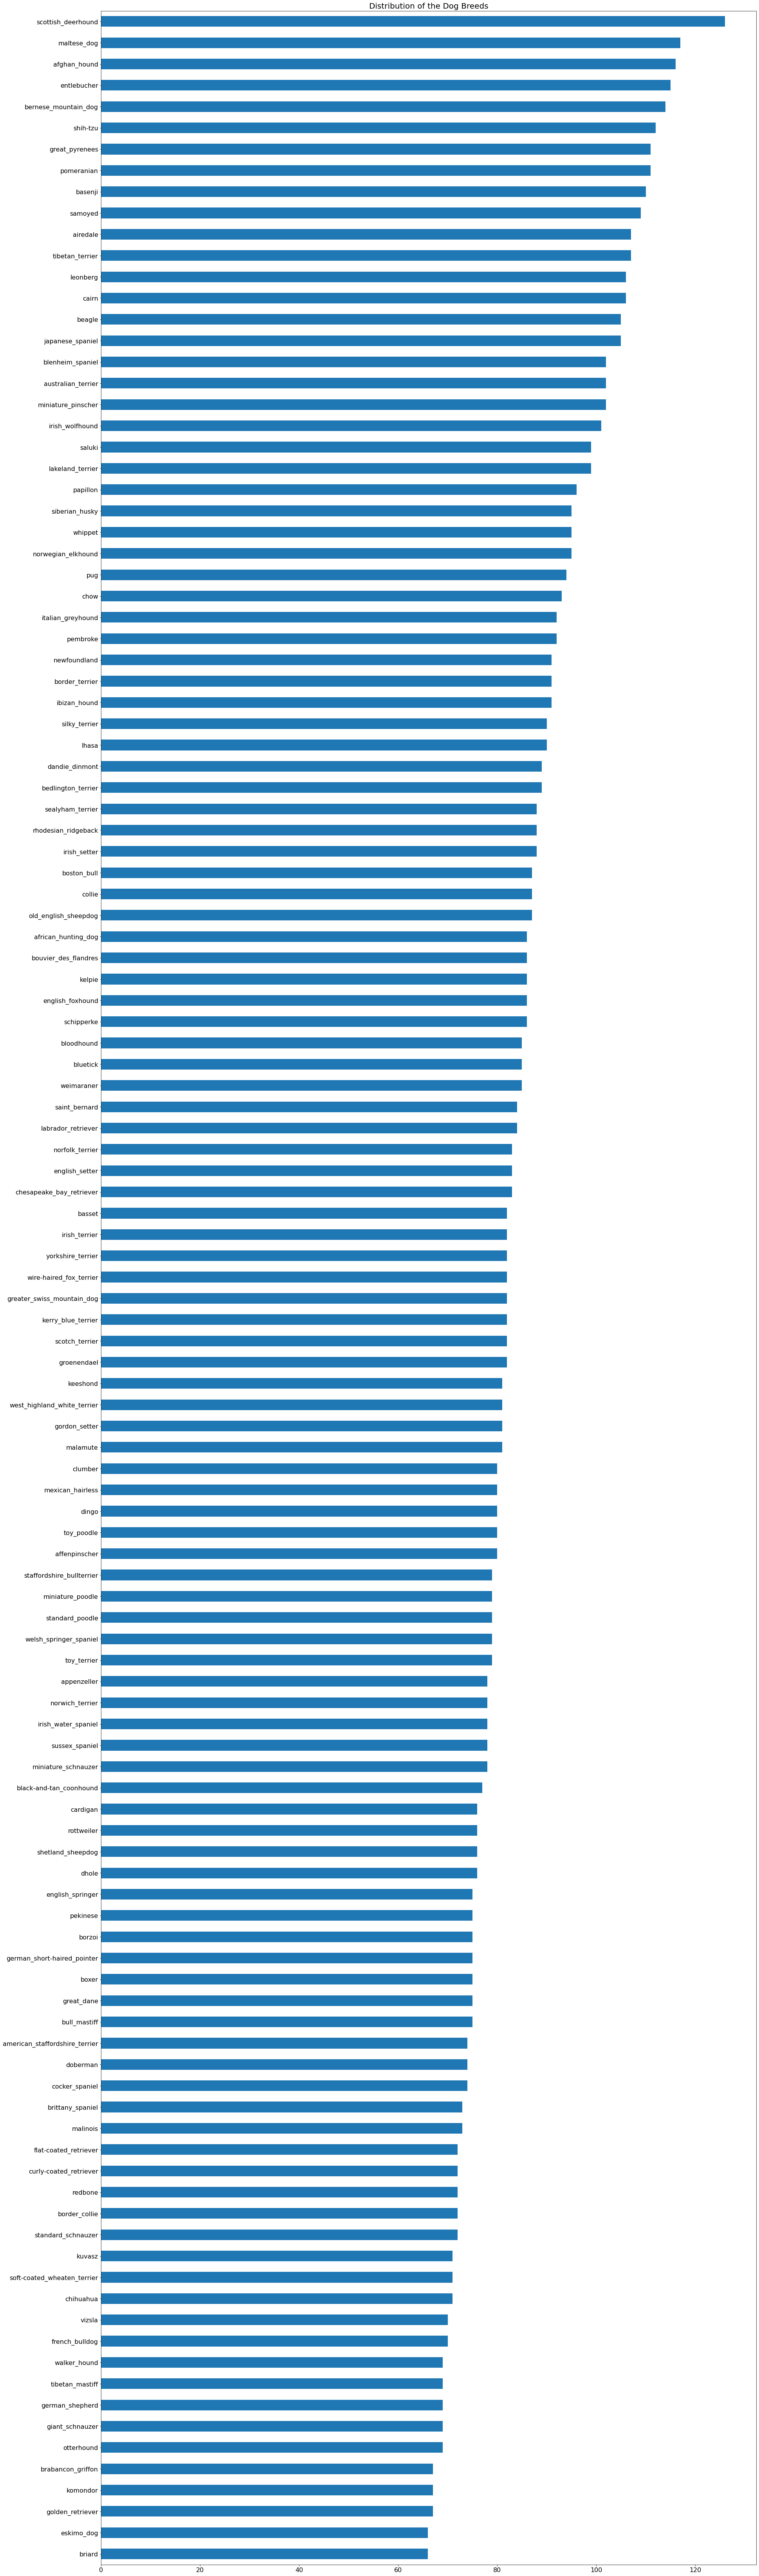

In [50]:
bar = data_df["breed"].value_counts(ascending=True).plot.barh(figsize = (30,120))
plt.title("Distribution of the Dog Breeds", fontsize = 20)
bar.tick_params(labelsize=16)
plt.show()

In [51]:
data_df["breed"].value_counts(ascending=False)

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
komondor                 67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

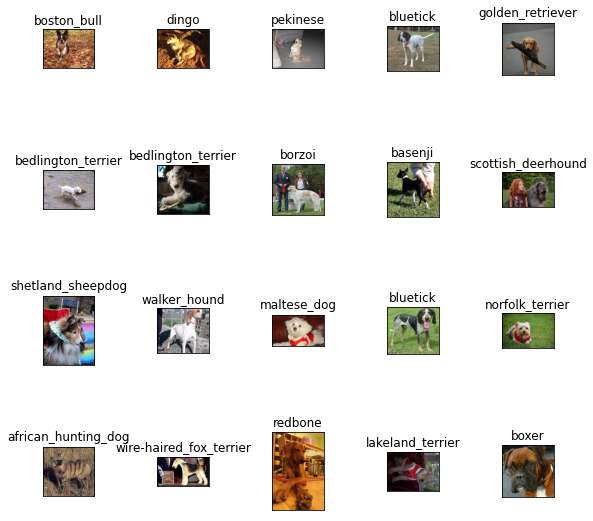

In [52]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data_df.path_img[i]))
    ax.set_title(data_df.breed[i])
plt.tight_layout()
plt.show()

In [53]:
class DogDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['id'], row['lbl']
        img_fname = self.root_dir + "/" + str(img_id) + ".jpg"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, img_label

In [55]:
imagenet_stats = ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
train_tfms = T.Compose([
    T.Resize((300,300)),
#    T.CenterCrop(256),
#    T.RandomCrop(32, padding=4, padding_mode='reflect'),
    T.ToTensor(),
    T.Normalize(*imagenet_stats,inplace=True), 
#    T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
    T.Resize((300,300)),
    #T.CenterCrop(256),
    T.ToTensor(),
    T.Normalize(*imagenet_stats)
])

In [56]:
msk = np.random.rand(len(data_df)) < 0.8

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

In [57]:
train_ds = DogDataset(train_df, TRAIN_DIR, transform=train_tfms)
val_ds = DogDataset(val_df, TRAIN_DIR, transform=valid_tfms)
len(train_ds), len(val_ds)

(8129, 2093)

In [58]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', labels[target])

Labels: english_foxhound


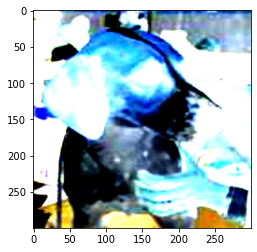

In [59]:
show_sample(*train_ds[241])

Labels: japanese_spaniel


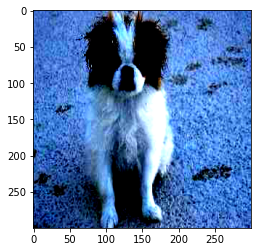

In [60]:
show_sample(*train_ds[419], invert=False)

In [63]:
batch_size = 128

In [64]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, 
                    num_workers=3, pin_memory=True)

In [65]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

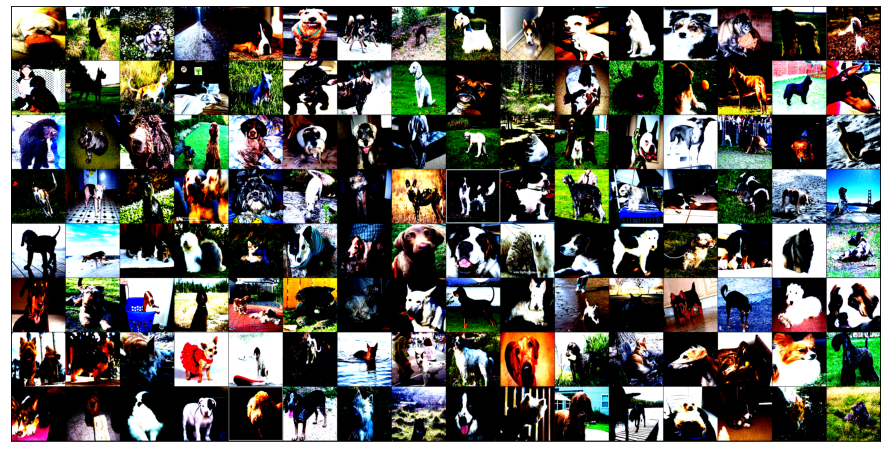

In [66]:
show_batch(train_dl, invert=False)

In [67]:
def accuracy(output, label):
    _, pred = torch.max(output, dim=1)
    return torch.tensor(torch.sum(pred == label).item() / len(pred))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, targets) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, targets)   # Calculate loss
        acc = accuracy(out, targets)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.8f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [68]:
resnet34 = models.AlexNet()
resnet34

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [69]:
class DogResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs,120)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [70]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [71]:
device = get_default_device()
device

device(type='cuda')

In [72]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [73]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [74]:
model = to_device(DogResnet34(), device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [75]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 4.806690216064453, 'val_acc': 0.00390625}]

In [76]:
model.freeze()

In [77]:
epochs = 5
max_lr = 0.0001
grad_clip = 0.5
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [78]:
%%time
starttime= time.time()
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.00007554, train_loss: 4.7167, val_loss: 4.4859, val_acc: 0.3607



Epoch [1], last_lr: 0.00009505, train_loss: 4.3154, val_loss: 4.1784, val_acc: 0.7126



Epoch [2], last_lr: 0.00006113, train_loss: 4.0717, val_loss: 4.0641, val_acc: 0.7448



Epoch [3], last_lr: 0.00001883, train_loss: 3.9786, val_loss: 4.0359, val_acc: 0.7699



Epoch [4], last_lr: 0.00000000, train_loss: 3.9522, val_loss: 4.0345, val_acc: 0.7664
CPU times: user 1min 17s, sys: 47.3 s, total: 2min 4s
Wall time: 6min 29s


In [80]:
model.unfreeze()

In [81]:
%%time
max_lr = max_lr/10

#epochs = epochs-1  
#grad_clip = grad_clip/5
#weight_decay = weight_decay/10

history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.00000755, train_loss: 3.9488, val_loss: 4.0325, val_acc: 0.7715



Epoch [1], last_lr: 0.00000950, train_loss: 3.9386, val_loss: 4.0224, val_acc: 0.7774



Epoch [2], last_lr: 0.00000611, train_loss: 3.9242, val_loss: 4.0176, val_acc: 0.7774



Epoch [3], last_lr: 0.00000188, train_loss: 3.9156, val_loss: 4.0161, val_acc: 0.7787



Epoch [4], last_lr: 0.00000000, train_loss: 3.9124, val_loss: 4.0160, val_acc: 0.7787
CPU times: user 1min 16s, sys: 46 s, total: 2min 2s
Wall time: 6min 20s


In [82]:
endtime=time.time()

duration=endtime-starttime
train_time=time.strftime('%M:%S', time.gmtime(duration))
train_time

'13:06'

In [83]:
def plot_scores(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('accuracy vs. No. of epochs');


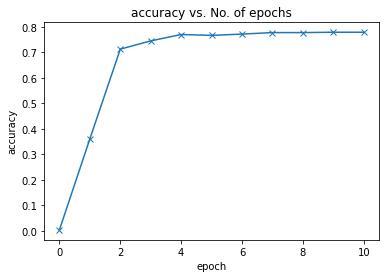

In [84]:
plot_scores(history)

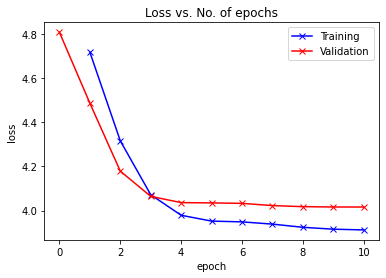

In [85]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)


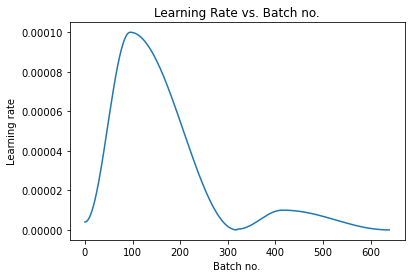

In [86]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [87]:
weights_fname = 'dog-resnet.pth'
torch.save(model.state_dict(), weights_fname)